# ACME CALL LOG PREDICTION

## Goals
Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

Success Metric(s):

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

Bonus(es):

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.

# SUMMARY

Given the dataset is highly unbalanced. The data is balance using SMOTE, and several classification models are tested.

## 1. Classification

### 1.1 Logistic regression model with weighted avg f-1 score of 0.9 is chosen. It also yields the best recall on the minority class of subscribers meaning that considering there are potential subscribers in the audience (dataset), the model can capture the the 88% of these possible subscriptions. 

### 1.2 The precision for the minority class is very low for all models due to the unbalanced nature and even though the false positive rate in the majority class is low the imbalanced ratio of the instances of the two class affects the precision of the minority class negatively.

## 2. The most important feature that affects the positive outcome is the DURATION of the call made to the customer which can be observed both on the heatmap and the feature selection model based on random forest.

## 3. Clustering

### Cluster2- Not Likely 
  * Has low balance
  * In Debt
  * Has Default Credit (unpaid in time)

### Cluster0- Neutral 
   * Within the Age Group (which the most positive responses are collected) 
   * Has average balance 
   * No default 
   * In debt

### Cluster1- More Likely 
   * Within the Age Group (which the most positive responses are collected)
   * Very High Balance
   * Not in debt
   * No default


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,log_loss,classification_report,confusion_matrix
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

In [69]:
data = pd.read_csv("C:/Users/DELL/Desktop/term-deposit-marketing-2020.csv", sep=',' ) 
dataframe = pd.DataFrame(data)
print(dataframe.shape)
dataframe.head()

(40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [70]:
dataframe.dtypes
for col in dataframe.columns:  #checking the quantity of labels in each column
    print(col,": ",len(dataframe[col].unique()),'labels')

age :  70 labels
job :  12 labels
marital :  3 labels
education :  4 labels
default :  2 labels
balance :  6849 labels
housing :  2 labels
loan :  2 labels
contact :  3 labels
day :  31 labels
month :  11 labels
duration :  1535 labels
campaign :  48 labels
y :  2 labels


In [71]:
print(dataframe['job'].unique())
print(dataframe['marital'].unique())
print(dataframe['education'].unique())
print(dataframe['contact'].unique())

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
['married' 'single' 'divorced']
['tertiary' 'secondary' 'unknown' 'primary']
['unknown' 'cellular' 'telephone']


In [72]:
dataframe.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [73]:
dataframe['y']=dataframe['y'].apply(lambda x: 1 if (x=='yes')  else 0)
dataframe['loan']=dataframe['loan'].apply(lambda x: 1 if (x=='yes')  else 0)
dataframe['housing']=dataframe['housing'].apply(lambda x: 1 if (x=='yes')  else 0)
dataframe['default']=dataframe['default'].apply(lambda x: 1 if (x=='yes')  else 0)

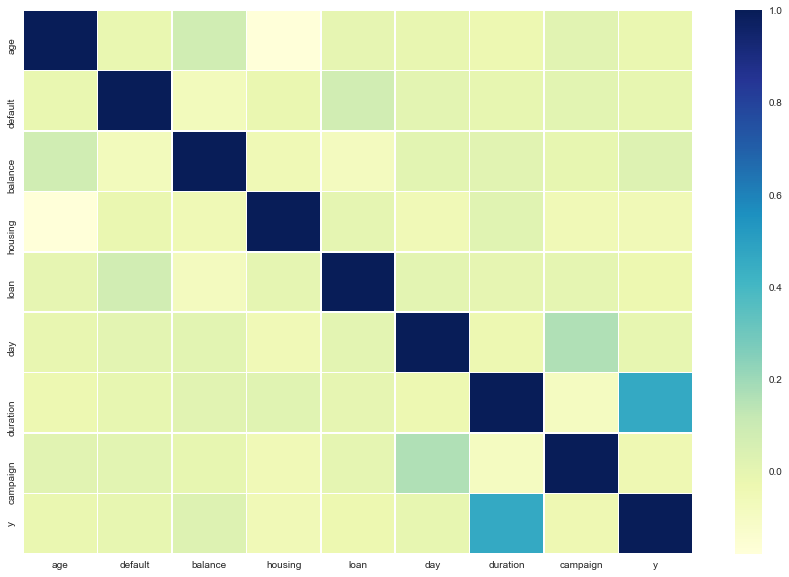

In [74]:
plt.figure(figsize=(15,10))
sns.heatmap(dataframe.corr(),linewidths=.5,cmap="YlGnBu")
plt.show()

In [75]:
df = pd.get_dummies(data=dataframe, columns=['job','marital','education','contact','month'],drop_first=True)


In [76]:
df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_telephone',
       'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct'],
      dtype='object')

In [263]:
df.head()

,age,default,balance,housing,loan,day,duration,campaign,y,job_blue-collar,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,cluster_num
0,58,0,2143,1,0,5,261,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1,44,0,29,1,0,5,151,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,33,0,2,1,1,5,76,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,47,0,1506,1,0,5,92,1,0,1,...,0,0,0,0,0,0,1,0,0,1
4,33,0,1,0,0,5,198,1,0,0,...,0,0,0,0,0,0,1,0,0,1


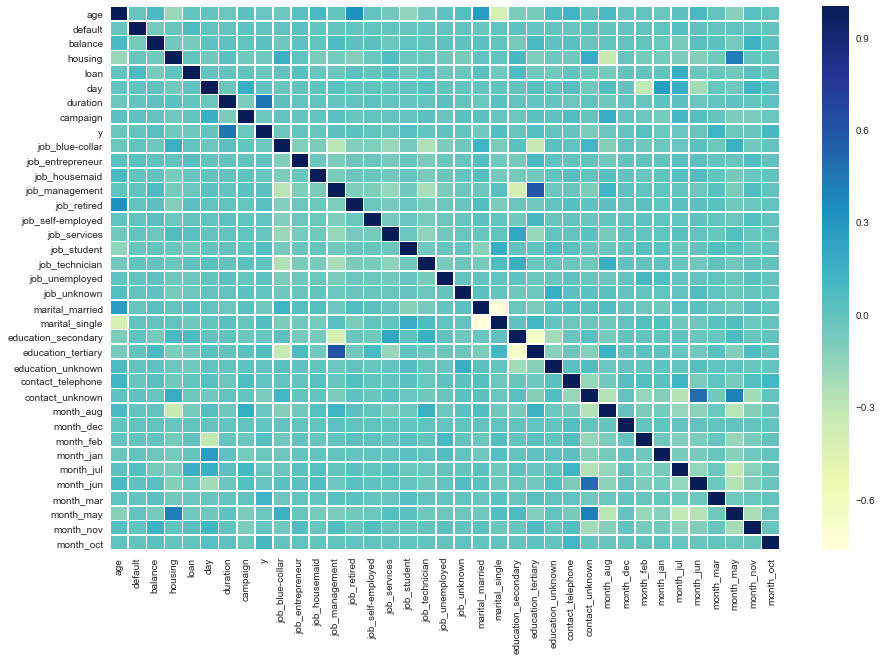

In [78]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),linewidths=.5,cmap="YlGnBu")
plt.show()

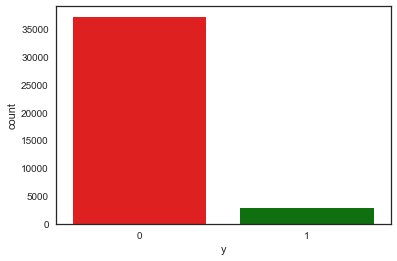

0    37104
1     2896
Name: y, dtype: int64


In [14]:
sns.set(style="white")
custom_palette = ["red","green"]
sns.set_palette(custom_palette)
sns.countplot(df['y'],label="Count")
plt.show()
print(df['y'].value_counts())

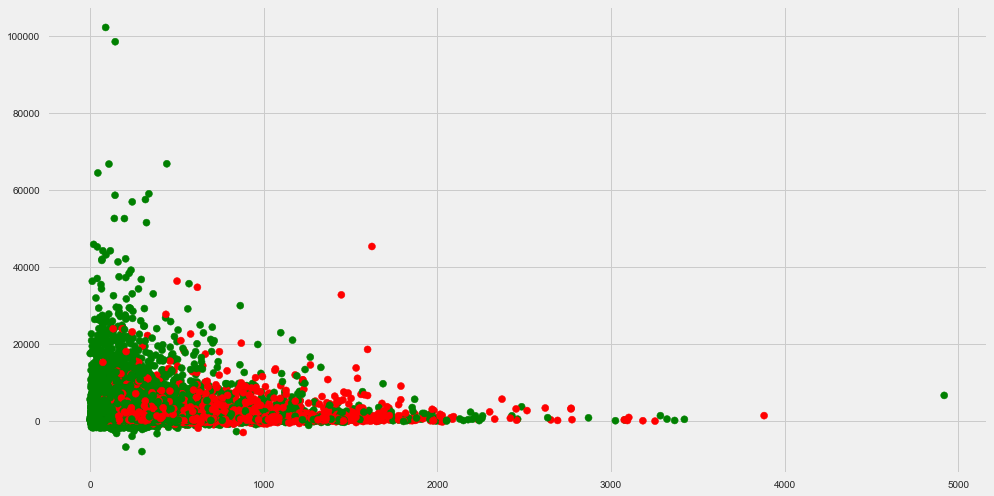

In [295]:
plt.figure(figsize=(15,8))
col = df.y.map({0:'g', 1:'r'})
plt.scatter(df['duration'] , df['balance'], c=col)
plt.show()

y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

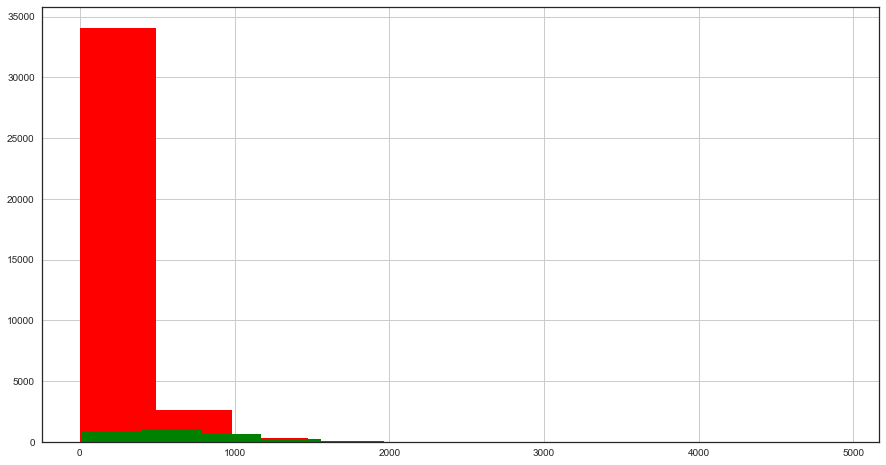

In [42]:
plt.figure(figsize=(15,8))
df.groupby("y").duration.hist()


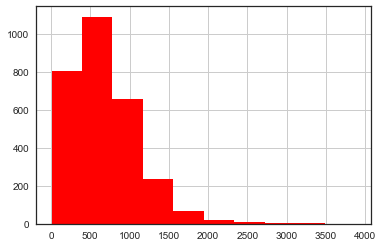

In [43]:
df[df["y"]==1].duration.hist()

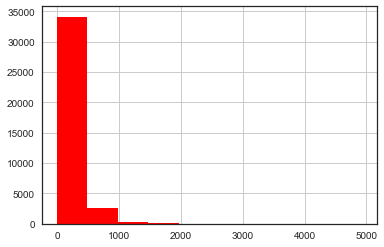

In [50]:
df[df["y"]==0].duration.hist()

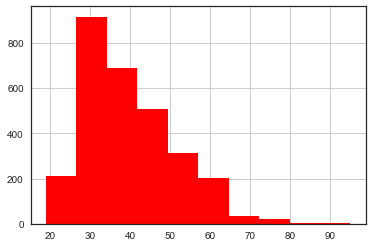

In [49]:
df[df["y"]==1].age.hist()

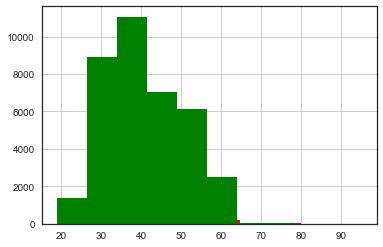

In [48]:

df[df["y"]==0].age.hist()

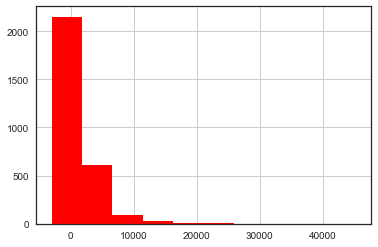

In [55]:
df[df["y"]==1].balance.hist()

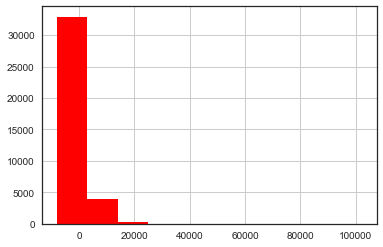

In [56]:
df[df["y"]==0].balance.hist()

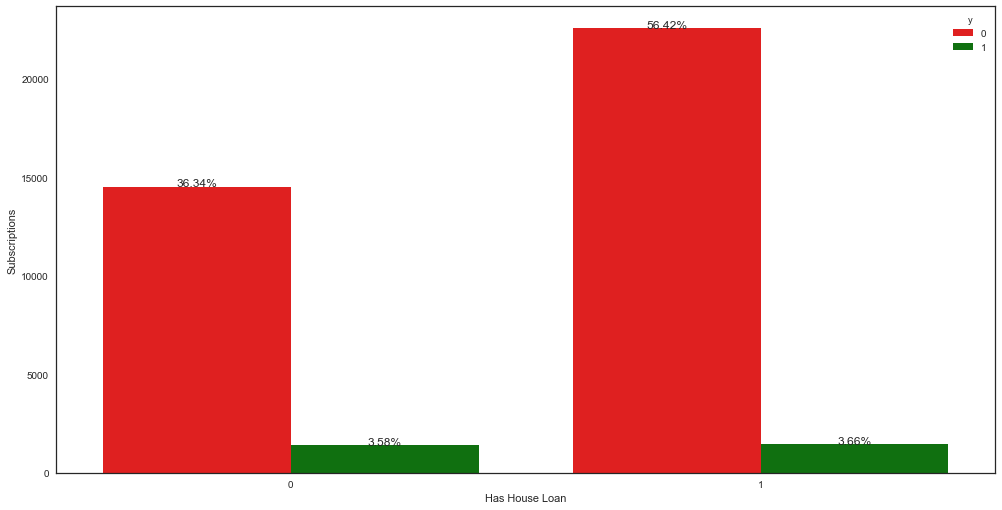

In [433]:
plt.figure(figsize=(15,8))
sns.set(style="white")
custom_palette = ["red","green"]
sns.set_palette(custom_palette)
total = float(len(df)) # one person per row 
ax = sns.countplot(x="housing", hue="y", data=dataframe) # for Seaborn version 0.7 and more
ax.set(xlabel="Has House Loan", ylabel = "Subscriptions")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

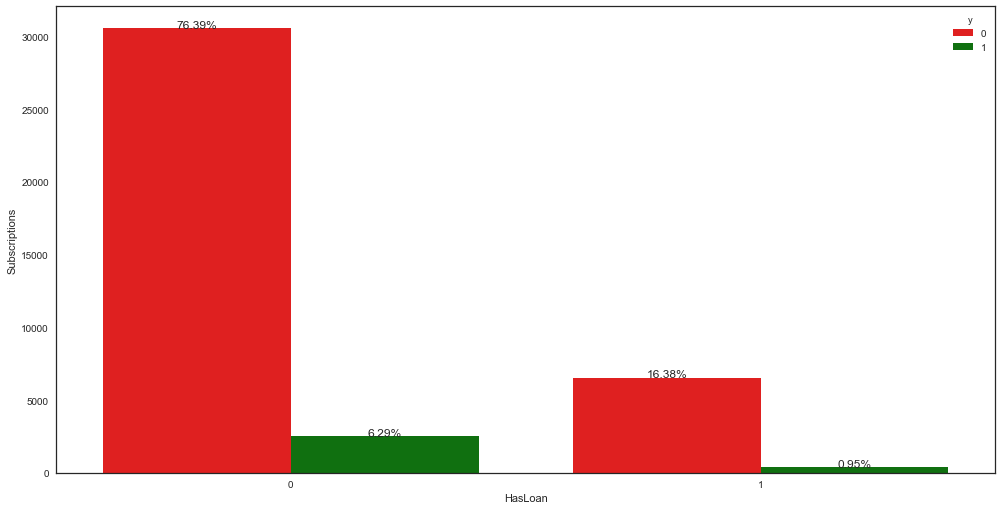

In [434]:
plt.figure(figsize=(15,8))
sns.set(style="white")
custom_palette = ["red","green"]
sns.set_palette(custom_palette)
total = float(len(df)) # one person per row 
ax = sns.countplot(x="loan", hue="y", data=dataframe) # for Seaborn version 0.7 and more
ax.set(xlabel="HasLoan", ylabel = "Subscriptions")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

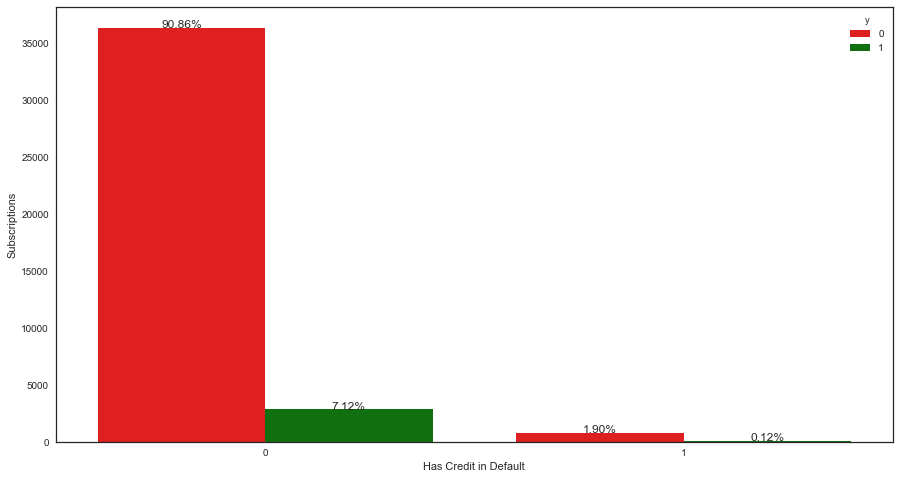

In [51]:
plt.figure(figsize=(15,8))
sns.set(style="white")
custom_palette = ["red","green"]
sns.set_palette(custom_palette)
total = float(len(df)) # one person per row 
ax = sns.countplot(x="default", hue="y", data=dataframe) # for Seaborn version 0.7 and more
ax.set(xlabel="Has Credit in Default", ylabel = "Subscriptions")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

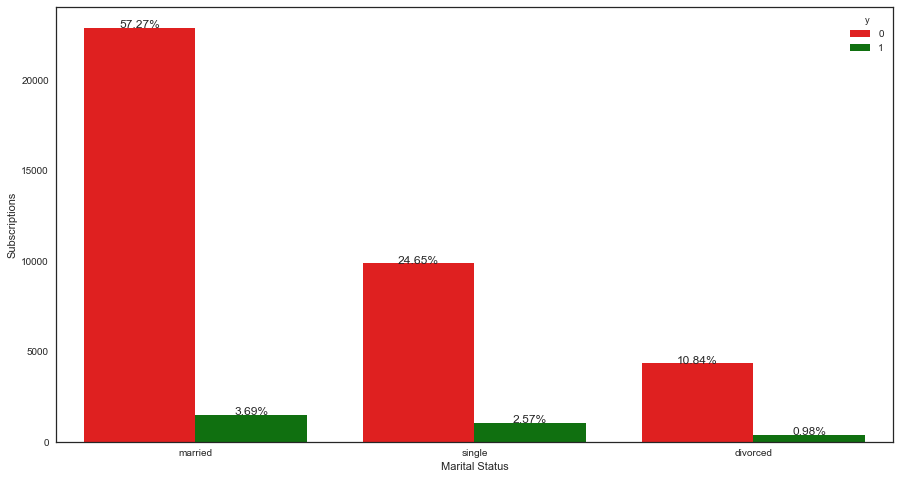

In [23]:
plt.figure(figsize=(15,8))
sns.set(style="white")
custom_palette = ["red","green"]
sns.set_palette(custom_palette)
total = float(len(df)) # one person per row 
ax = sns.countplot(x="marital", hue="y", data=dataframe) # for Seaborn version 0.7 and more
ax.set(xlabel="Marital Status", ylabel = "Subscriptions")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

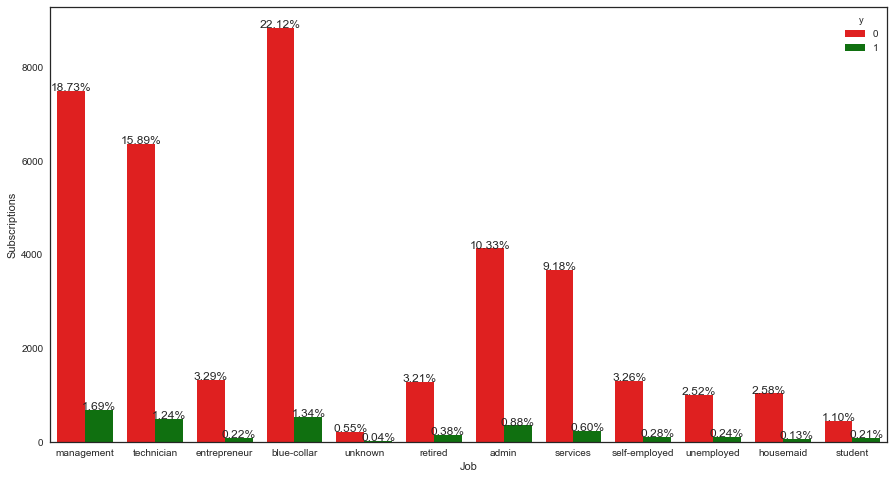

In [16]:
plt.figure(figsize=(15,8))
sns.set(style="white")
custom_palette = ["red","green"]
sns.set_palette(custom_palette)
total = float(len(df)) # one person per row 
ax = sns.countplot(x="job", hue="y", data=dataframe) # for Seaborn version 0.7 and more
ax.set(xlabel="Job", ylabel = "Subscriptions")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center") 
plt.show()

## tSNE PCA Visualization

In [18]:
from sklearn.decomposition import PCA
pca_scores = PCA().fit_transform(df)
# create a dataframe of pca_scores
df_pc = pd.DataFrame(pca_scores)

# perform t-SNE on PCs scores
# we will use first 50 PCs but this can vary
from sklearn.manifold import TSNE
tsne_em = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12, n_iter=1000, learning_rate=368, verbose=1).fit_transform(df_pc.loc[:,0:9])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.110s...
[t-SNE] Computed neighbors for 40000 samples in 1.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sam

In [19]:
df['tsne-2d-one'] = tsne_em[:,0]
df['tsne-2d-two'] = tsne_em[:,1]

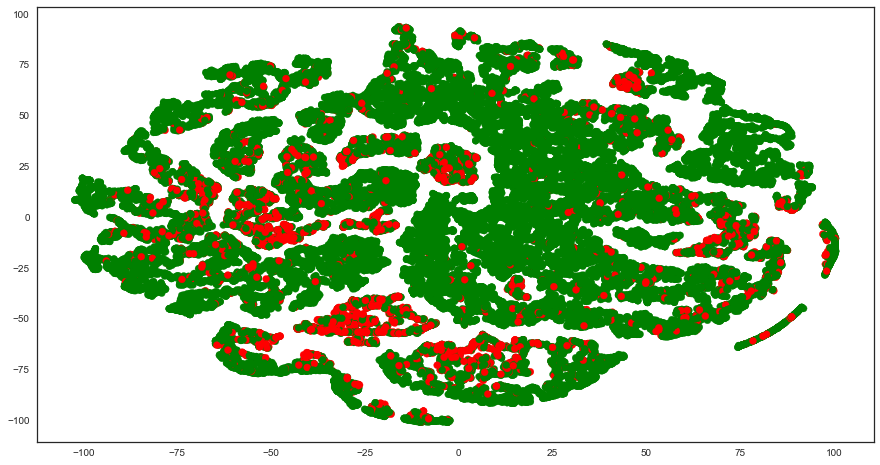

In [60]:
plt.figure(figsize=(15,8))
col = df.y.map({0:'g', 1:'r'})
plt.scatter(df['tsne-2d-one'] , df['tsne-2d-two'], c=col)
plt.show()

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "blue")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "blue")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Feature Selection

In [64]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

In [142]:
X=df.drop(columns=["y"])
y=df[["y"]]

In [81]:
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, y)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor(n_estimators=250, random_state=0)

Feature ranking:
1. feature 6 duration (0.340804)
2. feature 5 day (0.098461)
3. feature 0 age (0.080096)
4. feature 2 balance (0.074813)
5. feature 7 campaign (0.057246)
6. feature 21 education_secondary (0.019589)
7. feature 3 housing (0.019411)
8. feature 16 job_technician (0.018122)
9. feature 4 loan (0.017760)
10. feature 32 month_mar (0.017077)
11. feature 8 job_blue-collar (0.016679)
12. feature 19 marital_married (0.016500)
13. feature 11 job_management (0.016469)
14. feature 22 education_tertiary (0.016153)
15. feature 33 month_may (0.015726)
16. feature 20 marital_single (0.015236)
17. feature 34 month_nov (0.012235)
18. feature 14 job_services (0.012175)
19. feature 31 month_jun (0.011459)
20. feature 25 contact_unknown (0.011089)
21. feature 30 month_jul (0.011050)
22. feature 29 month_jan (0.011039)
23. feature 26 month_aug (0.010703)
24. feature 35 month_oct (0.009217)
25. feature 24 contact_telephone (0.009066)
26. feature 23 education_unknown (0.008784)
27. feature 13 j

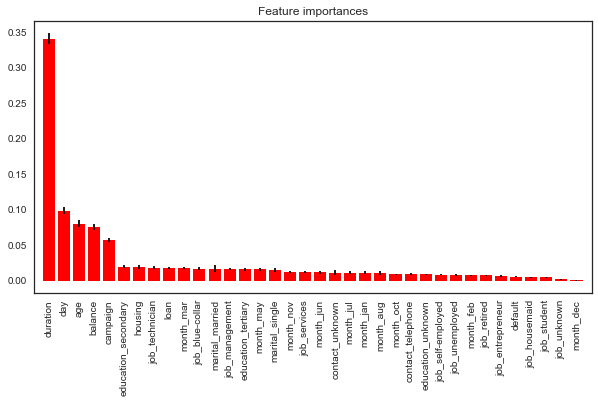

In [82]:

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center",)
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [96]:
from sklearn.feature_selection import SelectFromModel
feature_selection_model = SelectFromModel(forest,threshold="median", prefit=True)
X_selected_features_forest = feature_selection_model.transform(X)
X_selected_features_forest.shape

(40000, 18)

In [143]:
X = preprocessing.StandardScaler().fit(X).transform(X)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (28000, 36) (28000, 1)
Test set: (12000, 36) (12000, 1)


## Balance The Highly Unbalance Data Set

In [85]:
!pip install joblib

You should consider upgrading via the 'c:\users\dell\anaconda3\python.exe -m pip install --upgrade pip' command.


In [86]:
import sys
import six
import joblib
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [145]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Decision Tree Classification

In [146]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(DecisionTreeClassifier(), X_res, y_res, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.938


In [147]:
DT = DecisionTreeClassifier()
DT.fit(X_res,y_res)
predTree = DT.predict(X_test)

In [148]:
print(classification_report(y_test, predTree)) 

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     11131
           1       0.38      0.54      0.45       869

    accuracy                           0.90     12000
   macro avg       0.67      0.73      0.70     12000
weighted avg       0.92      0.90      0.91     12000



In [149]:
cm = confusion_matrix(y_test, predTree)
target_names = ['no', 'yes']

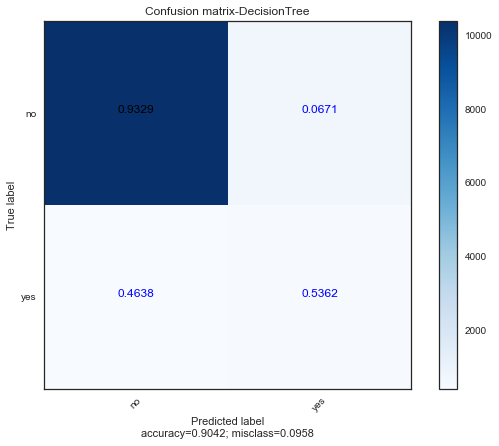

In [150]:
plot_confusion_matrix(cm,target_names, normalize=True,
                          title='Confusion matrix-DecisionTree')

## SVM Classification

In [151]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [153]:
param_grid = {'C': [0.1, 1, 10],   
              'kernel': ['rbf','sigmoid','linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_res, y_res) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.1, kernel=rbf, score=0.900, total=  54.3s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.2s remaining:    0.0s


[CV] ................... C=0.1, kernel=rbf, score=0.907, total=  58.2s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ................... C=0.1, kernel=rbf, score=0.912, total=  57.5s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................... C=0.1, kernel=rbf, score=0.910, total=  57.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................... C=0.1, kernel=rbf, score=0.908, total=  57.0s
[CV] C=0.1, kernel=sigmoid ...........................................
[CV] ............... C=0.1, kernel=sigmoid, score=0.827, total= 1.2min
[CV] C=0.1, kernel=sigmoid ...........................................
[CV] ............... C=0.1, kernel=sigmoid, score=0.829, total= 1.2min
[CV] C=0.1, kernel=sigmoid ...........................................
[CV] ............... C=0.1, kernel=sigmoid, score=0.837, total= 1.1min
[CV] C=0.1, kernel=sigmoid ...........................................
[CV] ............... C=0.1, kernel=sigmoid, score=0.836, total= 1.1min
[CV] C=0.1, kernel=sigmoid ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 76.3min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             verbose=3)

In [154]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'kernel': 'rbf'}
SVC(C=10)


In [155]:
grid_predictions= grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     11131
           1       0.39      0.63      0.48       869

    accuracy                           0.90     12000
   macro avg       0.68      0.77      0.71     12000
weighted avg       0.93      0.90      0.91     12000



In [156]:
cm = confusion_matrix(y_test, grid_predictions)

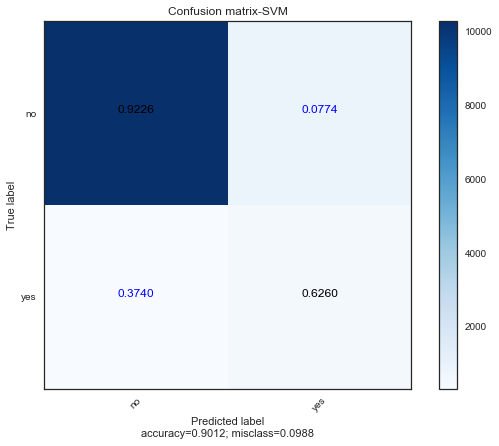

In [157]:
plot_confusion_matrix(cm,target_names, normalize=True,
                          title='Confusion matrix-SVM')

## Logistic Regression Classification

In [158]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(LogisticRegression(), X_res, y_res, scoring='f1_micro', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.886


In [159]:
logreg = LogisticRegression()
logreg.fit(X_res,y_res)
pred_logreg = logreg.predict(X_test)

In [160]:
print(classification_report(y_test, pred_logreg)) 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     11131
           1       0.35      0.85      0.49       869

    accuracy                           0.87     12000
   macro avg       0.67      0.86      0.71     12000
weighted avg       0.94      0.87      0.90     12000



In [161]:
cm = confusion_matrix(y_test, pred_logreg)

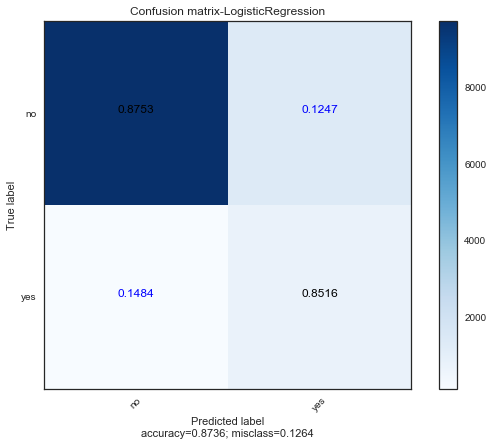

In [162]:
plot_confusion_matrix(cm,target_names, normalize=True,
                          title='Confusion matrix-LogisticRegression')

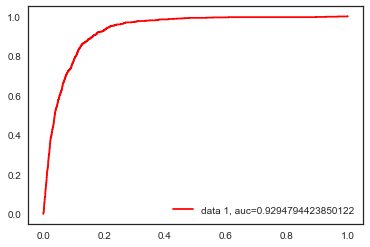

In [163]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [164]:
pred_proba_df = pd.DataFrame(logreg.predict_proba(X_test))
threshold_list = [0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.5 ******
Our testing accuracy is 0.8735833333333334
[[9743 1388]
 [ 129  740]]

******** For i = 0.55 ******
Our testing accuracy is 0.88325
[[9891 1240]
 [ 161  708]]

******** For i = 0.6 ******
Our testing accuracy is 0.8915833333333333
[[10029  1102]
 [  199   670]]

******** For i = 0.65 ******
Our testing accuracy is 0.8985
[[10144   987]
 [  231   638]]

******** For i = 0.7 ******
Our testing accuracy is 0.90775
[[10279   852]
 [  255   614]]

******** For i = 0.75 ******
Our testing accuracy is 0.9135833333333333
[[10387   744]
 [  293   576]]

******** For i = 0.8 ******
Our testing accuracy is 0.9188333333333333
[[10491   640]
 [  334   535]]

******** For i = 0.85 ******


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


Our testing accuracy is 0.9245833333333333
[[10609   522]
 [  383   486]]

******** For i = 0.9 ******
Our testing accuracy is 0.9289166666666666
[[10718   413]
 [  440   429]]

******** For i = 0.95 ******
Our testing accuracy is 0.9324166666666667
[[10853   278]
 [  533   336]]

******** For i = 0.99 ******
Our testing accuracy is 0.93125
[[10983   148]
 [  677   192]]


## One Class SVM

In [169]:
from sklearn.svm import OneClassSVM 
train, test = train_test_split(df, stratify=y,test_size=.3,random_state=4) 
train_normal = train[train['y']==0] 
train_outliers = train[train['y']==1] 
outlier_prop = len(train_outliers) / len(train_normal) 
outlier_prop

0.07804258268201594

In [186]:
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.00001) 
trainNorm=train_normal.drop(columns=["y"])
svm.fit(trainNorm)

OneClassSVM(gamma=1e-05, nu=0.07804258268201594)

In [187]:
testAll=test.drop(columns=["y"])
y_pred = svm.predict(testAll)

In [188]:
print(np.unique(y_pred,return_counts = True))

(array([-1,  1], dtype=int64), array([ 1239, 10761], dtype=int64))


In [189]:
y_test=test[["y"]]

In [190]:
y_test['y'] = y_test['y'].replace(1,-1)


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [191]:
y_test['y'] = y_test['y'].replace(0,1)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [192]:
print(np.unique(y_test,return_counts = True))

(array([-1,  1], dtype=int64), array([  869, 11131], dtype=int64))


In [193]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

          -1       0.24      0.35      0.29       869
           1       0.95      0.92      0.93     11131

    accuracy                           0.87     12000
   macro avg       0.60      0.63      0.61     12000
weighted avg       0.90      0.87      0.88     12000



## Clustering Customer Profiles

## Hierarchical Clustering

In [255]:
import scipy.cluster.hierarchy as sch

In [453]:
customers_df = dataframe[["age","balance","housing","loan","default"]]

In [454]:
customers_df["InDebt"]= customers_df["housing"]| customers_df["loan"]

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [455]:
customers_df.drop(columns=["housing","loan"],inplace=True)

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [456]:
customers_df

,age,balance,default,InDebt
0,58,2143,0,1
1,44,29,0,1
2,33,2,0,1
3,47,1506,0,1
4,33,1,0,0
...,...,...,...,...
39995,53,395,0,0
39996,30,3340,0,0
39997,54,200,0,0
39998,34,1047,0,0


In [457]:
X_customers = preprocessing.StandardScaler().fit(customers_df).transform(customers_df)

In [458]:
X_customers

array([[ 1.81041533,  0.29917431, -0.14367496,  0.70315947],
       [ 0.35838246, -0.42885395, -0.14367496,  0.70315947],
       [-0.78250052, -0.43815233, -0.14367496,  0.70315947],
       ...,
       [ 1.3955488 , -0.36996425, -0.14367496, -1.42215251],
       [-0.67878388, -0.0782708 , -0.14367496, -1.42215251],
       [-0.26391735,  0.05776097, -0.14367496,  0.70315947]])

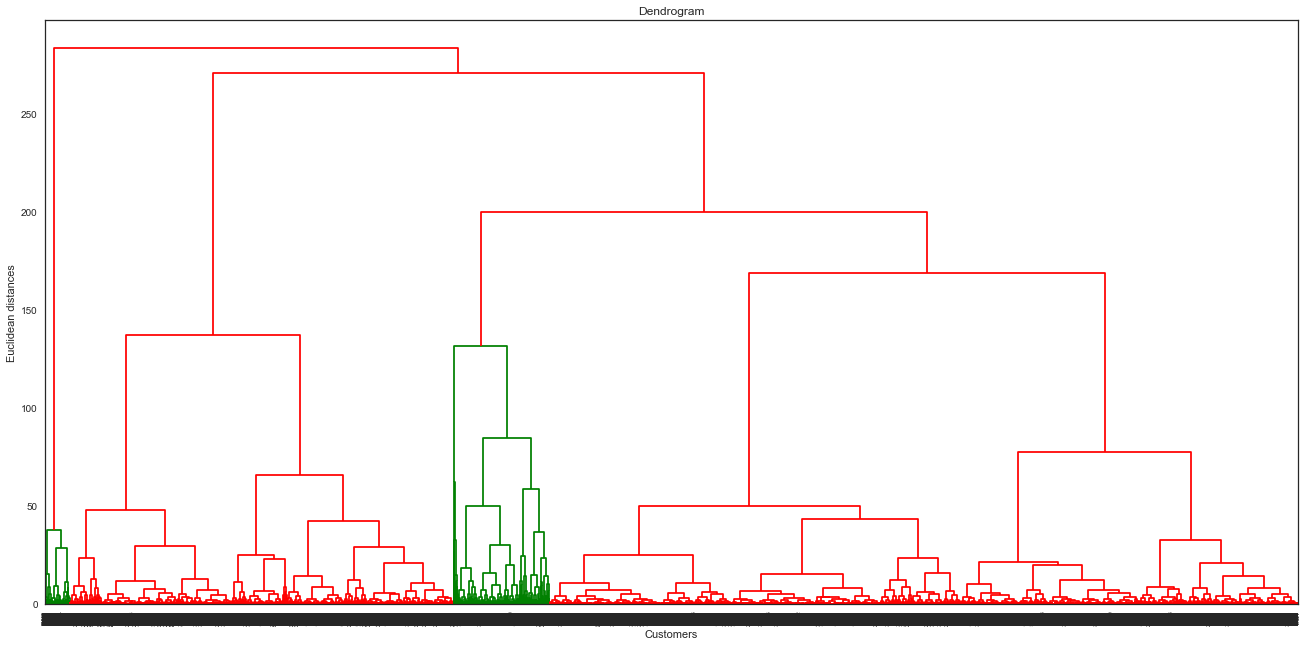

In [459]:
plt.figure(figsize=(20,10))
dendrogram = sch.dendrogram(sch.linkage(X_customers, method  = "ward"))

plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [473]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters =8, affinity = 'euclidean', linkage ='ward')

In [474]:
y_hc=hc.fit_predict(X_customers)

In [475]:
print('Silhouette Score for Hieararchial Clustering:'+str(metrics.silhouette_score(X_customers,y_hc,metric='euclidean')))
print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(X_customers,y_hc)))

Silhouette Score for Hieararchial Clustering:0.47323311361192955
Davies Bouldin Score:0.8613954146947522


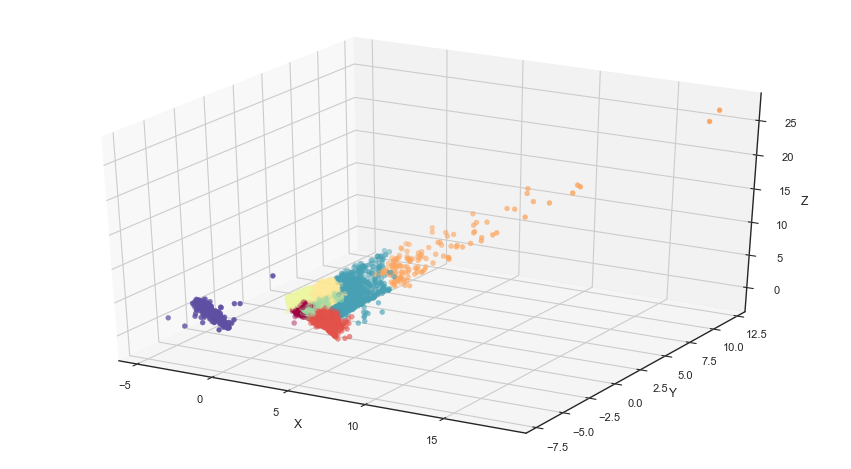

In [477]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit_transform(X_customers)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=y_hc,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

## Kmeans

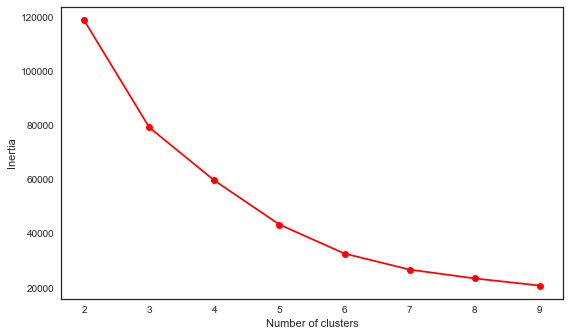

In [481]:

scores = []
for k in range(2,10):
    km = KMeans(n_clusters=k,random_state=123)
    km = km.fit(X_customers)
    scores.append(km.inertia_)
dfk = pd.DataFrame({'Cluster':range(2,10), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [494]:
for i in range(3,10):
    kmeans_labels=KMeans(n_clusters=i,random_state=123).fit_predict(X_customers)
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(X_customers,kmeans_labels, metric='euclidean').round(3)))

Silhouette score for 3 clusters k-means : 0.482 
Silhouette score for 4 clusters k-means : 0.501 
Silhouette score for 5 clusters k-means : 0.471 
Silhouette score for 6 clusters k-means : 0.503 
Silhouette score for 7 clusters k-means : 0.514 
Silhouette score for 8 clusters k-means : 0.454 
Silhouette score for 9 clusters k-means : 0.459 


In [495]:
for i in [3,4,5,6,7]:
    kmeans_labels=KMeans(n_clusters=i,random_state=123).fit_predict(X_customers)
    print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(X_customers,kmeans_labels).round(3)))

Davies Bouldin Score:0.808
Davies Bouldin Score:0.765
Davies Bouldin Score:0.695
Davies Bouldin Score:0.675
Davies Bouldin Score:0.681


In [552]:
kmeans_labels=KMeans(n_clusters=3,random_state=123).fit_predict(X_customers)

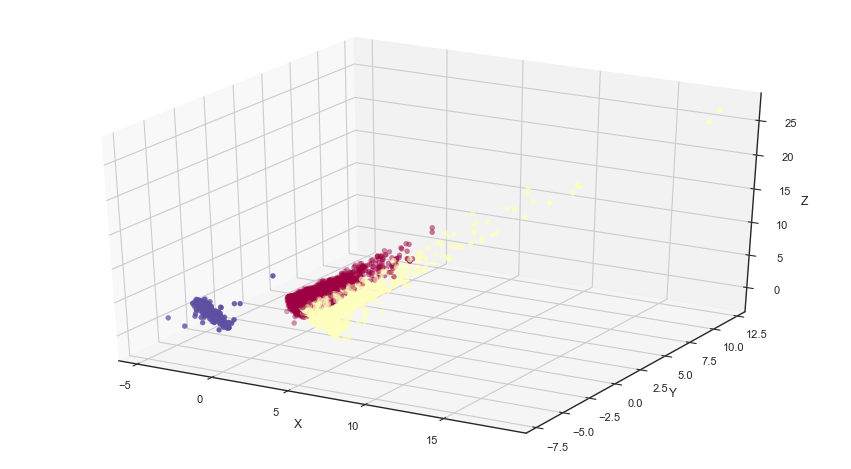

In [553]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

In [554]:
customers_df['Clusters']=list(kmeans_labels)
customers_df["y"]=dataframe["y"]
customers=pd.DataFrame(customers_df['Clusters'].value_counts()).rename(columns={'Clusters':'Number of Customers'})
customers.T

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2
Number of Customers,26154,13037,809


In [555]:
customers_df.set_index('Clusters')
grouped=customers_df.groupby(by='Clusters').mean().round(1)

In [556]:
cl2=customers_df[customers_df["Clusters"]==2]

In [568]:
cl2[cl2["y"]==0].count()

age         760
balance     760
default     760
InDebt      760
Clusters    760
y           760
dtype: int64

In [569]:
grouped

,age,balance,default,InDebt,y
Clusters,,,,,
0,39.5,1124.3,0.0,1.0,0.1
1,42.7,1663.0,0.0,0.0,0.1
2,39.5,-141.9,1.0,0.7,0.1


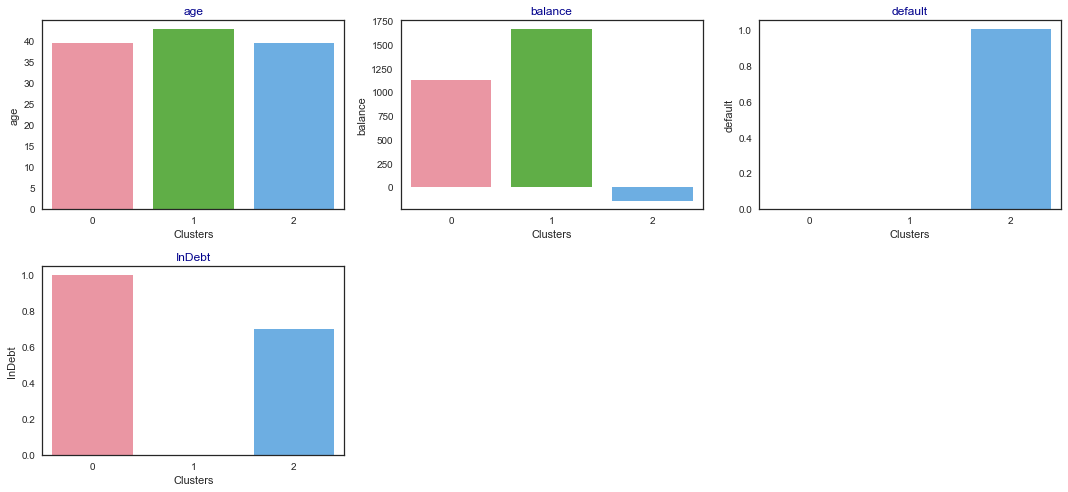

In [570]:

features=["age","balance","default","InDebt"]
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.barplot(grouped.index,grouped[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

### Cluster2- Not Likely
### Cluster0- Neutral
### Cluster1- More Likely